## **tf.data.Dataset**

In [2]:
import tensorflow as tf

In [ ]:
# from_tensor_slices()

numbers = [10, 20, 30, 40]
dataset = tf.data.Dataset.from_tensor_slices(numbers)

for element in dataset:
  print(element) # eveery element is a eager tensor

print('\n')
for element in dataset:
  print(element.numpy()) # convert to numpy array

tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(20, shape=(), dtype=int32)
tf.Tensor(30, shape=(), dtype=int32)
tf.Tensor(40, shape=(), dtype=int32)


10
20
30
40


In [ ]:
# map()

numbers = [10, 20, 30, 40]

dataset = tf.data.Dataset.from_tensor_slices(numbers)
dataset = dataset.map(lambda x: x * 2)

for element in dataset:
  print(element.numpy())

20
40
60
80


In [ ]:
# filter()

numbers = [10, 20, 30, 40]

dataset = tf.data.Dataset.from_tensor_slices(numbers)
dataset = dataset.filter(lambda x: x > 20)

for element in dataset:
  print(element.numpy())

30
40


In [ ]:
# cache

numbers = [10, 20, 30, 40]

dataset = tf.data.Dataset.from_tensor_slices(numbers).map(lambda x: x**2)
dataset = dataset.cache()

for element in dataset:
  print(element.numpy())

100
400
900
1600


In [ ]:
# prefetch()

numbers = [10, 20, 30, 40, 50]

dataset = tf.data.Dataset.from_tensor_slices(numbers).map(lambda x: x**2)
dataset = dataset.batch(2).prefetch(1) # or tf.data.AUTOMATE

for batch in dataset:
  print(batch.numpy())

[100 400]
[ 900 1600]
[2500]


In [ ]:
# shuffle()

numbers = [10, 20, 30, 40, 50]

dataset = tf.data.Dataset.from_tensor_slices(numbers).shuffle(buffer_size=3)

for element in dataset.take(4):
  print(element.numpy())

30
10
50
20


In [ ]:
# batch()

numbers = [10, 20, 30, 40, 50]

dataset = tf.data.Dataset.from_tensor_slices(numbers).batch(3)

for batch in dataset:
  print(batch.numpy())

[10 20 30]
[40 50]


In [ ]:
# repeat()

numbers = [10, 20, 30, 40]

dataset = tf.data.Dataset.from_tensor_slices(numbers).repeat(2)

for element in dataset:
  print(element.numpy())

10
20
30
40
10
20
30
40


In [3]:
# list_files()


dir = '../datasets/images'
dataset = tf.data.Dataset.list_files(dir + '/*/*').shuffle(True)

for element in dataset.take(5):
  print(element)

tf.Tensor(b'..\\datasets\\images\\ntr\\untitled-design-2024-02-08t021819.951-2024-02-51be7dbd5705cf41f4ebd52fd1f0f5ae.jpg', shape=(), dtype=string)
tf.Tensor(b'..\\datasets\\images\\ram_charan\\b3d532fa21a2816da393371a8a8c83a8.jpg', shape=(), dtype=string)
tf.Tensor(b'..\\datasets\\images\\pavan_kalyan\\7.jpg', shape=(), dtype=string)
tf.Tensor(b'..\\datasets\\images\\pavan_kalyan\\Bheemla-Nayak-Pawan-Kalyan-1200by667.jpg', shape=(), dtype=string)
tf.Tensor(b'..\\datasets\\images\\nagarjuna\\nagarjuna-akkineni1754300962_0.jpg', shape=(), dtype=string)


## **tf.data.Dataset on Image data**

In [4]:
# importing libraries

import tensorflow as tf
import os

data_dir = '../datasets/images'
img_height, img_width = 128, 128
batch_size = 32

In [ ]:
list_ds = tf.data.Dataset.list_files(os.path.join(data_dir, '*/*'), shuffle=True)

In [ ]:
# extracting class names

class_names = sorted(os.listdir(data_dir))
num_classes = len(class_names)

# mapping
class_to_index = {name: idx for idx, name in enumerate(class_names)}
print(class_to_index)

{'chiranjeevi': 0, 'nagarjuna': 1, 'ntr': 2, 'pavan_kalyan': 3, 'ram_charan': 4}


In [ ]:
def get_label(file_path):

  parts = tf.strings.split(file_path, os.path.sep)
  label = parts[-2]
  return tf.argmax(tf.cast(tf.equal(class_names, label), tf.int32))

In [ ]:
def load_image(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [img_height, img_width])
  img = img/255.0

  label = get_label(file_path)
  return img, label

In [ ]:
# final dataset

dataset = list_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = (
    dataset.shuffle(1000)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
dataset_size = sum(1 for _ in dataset.unbatch())
train_size = int(0.8*dataset_size)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

In [ ]:
import keras
from keras import layers

model = keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),  # regularization
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",  # labels are integers
    metrics=["accuracy"]
)

In [ ]:
# model training

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 737ms/step - accuracy: 0.2351 - loss: 1.9268
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 875ms/step - accuracy: 0.2455 - loss: 1.5993
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 943ms/step - accuracy: 0.2695 - loss: 1.5776
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 724ms/step - accuracy: 0.2093 - loss: 1.5453
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 722ms/step - accuracy: 0.3332 - loss: 1.4970
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 680ms/step - accuracy: 0.3639 - loss: 1.4607
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 680ms/step - accuracy: 0.4580 - loss: 1.3586
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3949 - loss: 1.3462
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step - accuracy: 0.5055 - loss: 1.1959
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 674ms/step - accuracy: 0.5465 - loss: 1.1175


## **image_dataset_from_Directory()**

In [ ]:
data_dir = '../datasets/images'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 137 files belonging to 5 classes.
Using 110 files for training.
Found 137 files belonging to 5 classes.
Using 27 files for validation.


In [ ]:
# class names

class_names = train_ds.class_names
print(class_names)

num_classes = len(class_names)

['chiranjeevi', 'nagarjuna', 'ntr', 'pavan_kalyan', 'ram_charan']


In [ ]:
# optimize dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [ ]:
# model training

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),  # normalize pixels

    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")   # multiclass output
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 947ms/step - accuracy: 0.2204 - loss: 2.2913 - val_accuracy: 0.2593 - val_loss: 1.7310
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 927ms/step - accuracy: 0.3094 - loss: 1.5572 - val_accuracy: 0.2963 - val_loss: 1.6231
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3100 - loss: 1.5973 - val_accuracy: 0.1481 - val_loss: 1.6011
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 933ms/step - accuracy: 0.3088 - loss: 1.5690 - val_accuracy: 0.1852 - val_loss: 1.6018
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 732ms/step - accuracy: 0.2477 - loss: 1.5503 - val_accuracy: 0.1852 - val_loss: 1.5807
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 888ms/step - accuracy: 0.4466 - loss: 1.4573 - val_accuracy: 0.2222 - val_loss: 1.5906
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4707 - loss: 1.3831 - val_accuracy: 0.2593 - val_loss: 1.6067
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 735ms/step - accuracy: 0.5323 - loss: 1.2826 - val_accuracy: 0.2963 - val_loss: 1.549

In [ ]:
#evaluation

test_loss, test_acc = model.evaluate(val_ds)
print(f'Test accuracy: {test_acc:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.4444 - loss: 1.5663
Test accuracy: 0.4444


# **Data Augmentation**

In [ ]:
from keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data_augmentation = keras.Sequential([
    layers.Resizing(224, 224),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.2)
])

In [ ]:
# loading image
import tensorflow as tf

image_path = '../datasets/cat.jpg'

img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.expand_dims(img, 0)

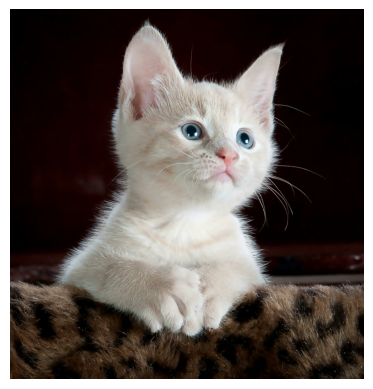

In [ ]:
# viewing original image

import matplotlib.pyplot as plt

plt.imshow(tf.squeeze(img).numpy().astype('uint8'))
plt.axis('off')
plt.show()

In [ ]:
augmented_images = [data_augmentation(img, training=True) for _ in range(12)]

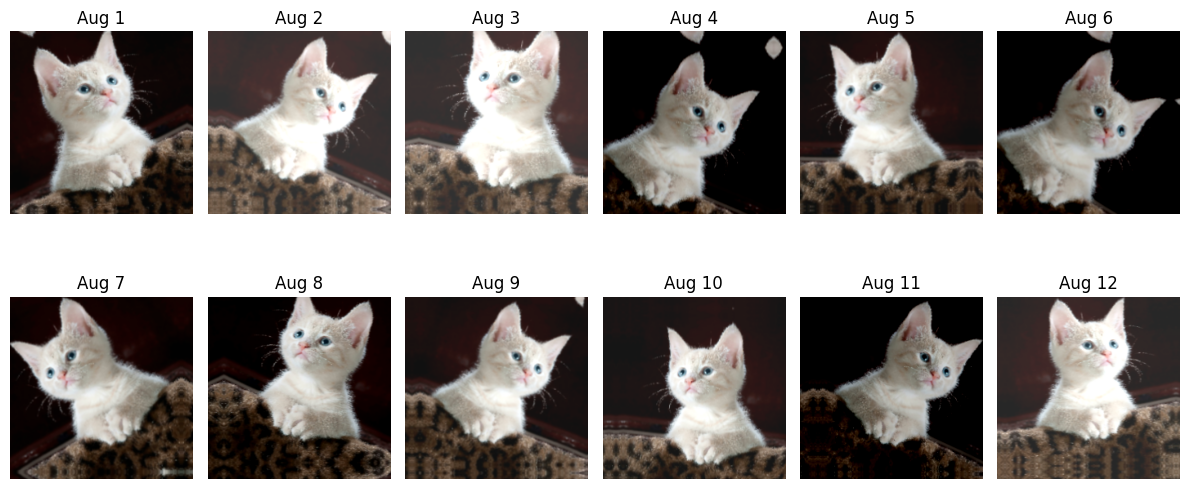

In [ ]:
plt.figure(figsize=(12, 6))

for i, aug_img in enumerate(augmented_images):
  plt.subplot(2, 6, i+1)
  plt.imshow(tf.squeeze(aug_img).numpy().astype('uint8'))
  plt.title(f"Aug {i+1}")
  plt.axis('off')
plt.tight_layout()
plt.show()

## ***Data Augementation on cifar10 dataset***

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [25]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.2)
])

In [26]:
(train_ds, val_ds), ds_info = tf.keras.datasets.cifar10.load_data(), None

In [27]:
def preprocess(image, label, training=False):
    image = tf.cast(image, tf.float32)
    image = resize_and_rescale(image)   # Always apply
    if training:
        image = data_augmentation(image)  # Only apply in training
    return image, label

In [28]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_ds[0], train_ds[1]))
train_dataset = (
    train_dataset
    .shuffle(1000)
    .map(lambda x, y: preprocess(x, y, training=True), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = tf.data.Dataset.from_tensor_slices((val_ds[0], val_ds[1]))
val_dataset = (
    val_dataset
    .map(lambda x, y: preprocess(x, y, training=False), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [29]:
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Conv2D(128, 3, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [30]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
model.fit(
    train_dataset.take(50),
    epochs=1,
    validation_data=val_dataset
)

50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 856ms/step - accuracy: 0.1154 - loss: 3.6468 - val_accuracy: 0.1000 - val_loss: 2.3026


For Understanding, 'ran a sample set only for 1 epoch'